In [42]:
## Import Libraries in this block ##

import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10,cifar100
from PIL import Image, ImageFile


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'DeepLearning'
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)
%cd /content/gdrive/MyDrive/DeepLearning
!ls

/content/gdrive/MyDrive/DeepLearning
AUTOENCODER.png			ImageCap_Data
best_model_c100.h5		MidTerm
best_model_c10.h5		model_inceptionv3.png
best_resnet_model_c100.h5	model_inceptionv.png
best_resnet_model_c10.h5	model.png
best_tf_resnet50_model_c100.h5	MR_CNN_model.h5
best_tf_resnet50_model_c10.h5	MultiresCNN-network.png
c10_resnet20_model.103.h5	PaaperPresentation.gslides
cat.png				resnet.png
cnn-y-network.png		sample_data
descriptions_test.txt		saved_images
descriptions.txt		saved_models
features_test_Inception.pkl	saved_models_mrc
features_test.pkl		saved_models_mt
features_train_Inception.pkl	VC_CNN_model.h5
features_train.pkl		VGG_CNN_model.h5


In [176]:
## Funtion to load and normalize data ##

def load_dataset(dataset):
  if dataset == "cifar10":
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, x_test) = cifar10.load_data()
    
  elif dataset == "cifar100":
    cifar100 = tf.keras.datasets.cifar100
    (x_train, y_train), (x_test, x_test) = cifar100.load_data(label_mode='fine')

  
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  print("Train Data shape for {}:{}{}".format(dataset,x_train.shape, y_train.shape))
  print("Test Data shape for {}:{}{}".format(dataset,x_test.shape, x_test.shape))

  return x_train, x_test,y_train,x_test

In [177]:
##Learning Rate Schedule ##
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [178]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [214]:
## Funtion to train , test and plot training curve ##

def train_test_plot(model, x_train, x_val, x_train_gray, x_val_gray,x_test,x_test_gray, optimizer,epochs,batch_size,cifar):

  
  # prepare model model saving directory.
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  model_name = 'colorized_ae_model_cifar'+str(cifar)+'_{epoch:03d}.h5'
  if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # Mean Square Error (MSE) loss function, Adam optimizer
  model.compile(loss='mse', optimizer=optimizer)

  # save weights for future use (e.g. reload parameters w/o training)
  checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

  # reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)



  # called every epoch
  callbacks = [lr_reducer, checkpoint]


  # train the autoencoder
  history=autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_val_gray, x_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

  # predict the autoencoder output from test data
  x_decoded = autoencoder.predict(x_test_gray)
  
  # display the 1st 100 colorized images
  imgs = x_decoded[:100]
  imgs = imgs.reshape((10, 10, 32,32,3))
  imgs = np.vstack([np.hstack(i) for i in imgs])
  plt.figure()
  plt.axis('off')
  plt.title('Colorized cifar{} test images (Predicted)'.format(cifar))
  plt.imshow(imgs, interpolation='none')
  plt.savefig('%s/colorized.png' % imgs_dir)
  plt.show()
  

  # Evaluate Model on Test set
  
  score = model.evaluate(x_test_gray,
                       x_test,
                       batch_size=batch_size,
                       verbose=1)
  print("\nTest loss: %.4f%" % (score))
  
  #Plot training curve
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


In [197]:
#Funtion to build autoencoder
def build_autoencoder(input_shape,layer_filters,kernel_size,latent_dim):

  inputs = Input(shape=input_shape, name='encoder_input')
  x = inputs
  # stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
  for filters in layer_filters:
      x = Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 strides=2,
                 activation='relu',
                 padding='same')(x)

  # shape info needed to build decoder model so we don't do hand computation
  # the input to the decoder's first Conv2DTranspose will have this shape
  # shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
  shape = K.int_shape(x)

  # generate a latent vector
  x = Flatten()(x)
  latent = Dense(latent_dim, name='latent_vector')(x)

  # instantiate encoder model
  encoder = Model(inputs, latent, name='encoder')
  encoder.summary()

  # build the decoder model
  latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
  x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
  x = Reshape((shape[1], shape[2], shape[3]))(x)

  # stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
  for filters in layer_filters[::-1]:
      x = Conv2DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          strides=2,
                          activation='relu',
                          padding='same')(x)

  outputs = Conv2DTranspose(filters=3,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            name='decoder_output')(x)

  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  decoder.summary()

  # autoencoder = encoder + decoder
  # instantiate autoencoder model
  autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
  autoencoder.summary()
  return autoencoder

In [189]:
def preprocess(x_train,x_val,x_test,cifar):
  
  
  # normalize output train and test color images
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  x_val = x_val.astype('float32') / 255
  
  # convert color train and test images to gray
  x_train_gray = rgb2gray(x_train)
  x_test_gray = rgb2gray(x_test)
  x_val_gray = rgb2gray(x_val)

  # normalize input train and test grayscale images
  x_train_gray = x_train_gray.astype('float32') / 255
  x_test_gray = x_test_gray.astype('float32') / 255
  x_val_gray = x_val_gray.astype('float32') / 255

  # reshape images to row x col x channel for CNN output/validation
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
  x_val= x_val.reshape(x_val.shape[0], img_rows, img_cols, channels)
  # reshape images to row x col x channel for CNN input
  x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
  x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)
  x_val_gray = x_val_gray.reshape(x_val_gray.shape[0], img_rows, img_cols, 1)

  # display the 1st 100 input images (color and gray)
  imgs = x_test[:100]
  imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
  imgs = np.vstack([np.hstack(i) for i in imgs])
  plt.figure()
  plt.axis('off')
  plt.title('Test cifar{} color images (Ground  Truth)'.format(cifar))
  plt.imshow(imgs, interpolation='none')
  plt.savefig('%s/test_color.png' % imgs_dir)
  plt.show()
  
  # display grayscale version of test images
  imgs = x_test_gray[:100]
  imgs = imgs.reshape((10, 10, img_rows, img_cols))
  imgs = np.vstack([np.hstack(i) for i in imgs])
  plt.figure()
  plt.axis('off')
  plt.title('Test cifar{} gray images (Input)'.format(cifar))
  plt.imshow(imgs, interpolation='none', cmap='gray')
  plt.savefig('%s/test_gray.png' % imgs_dir)
  plt.show()
  
  return x_train,x_train_gray,x_val,x_val_gray,x_test,x_test_gray

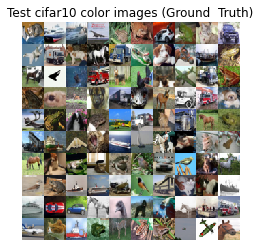

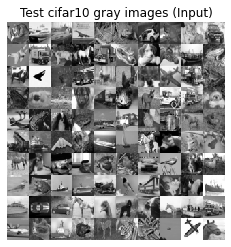

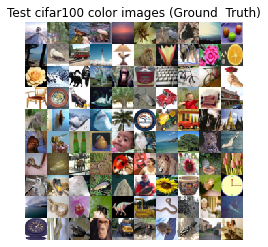

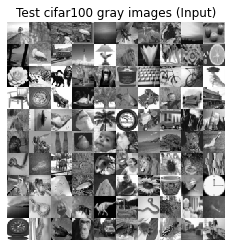

In [199]:
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_val = train_test_split(x_train, test_size = 0.2, random_state=1)


# load CIFAR100 data
(x_train_100, _), (x_test_100, _) = cifar100.load_data()
x_train_100, x_val_100 = train_test_split(x_train_100, test_size = 0.2, random_state=1)
# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

x_train,x_train_gray,x_val,x_val_gray,x_test,x_test_gray = preprocess(x_train,x_val,x_test,10)
x_train_100,x_train_gray_100,x_val_100,x_val_gray_100,x_test_100,x_test_gray_100 = preprocess(x_train_100,x_val_100,x_test_100,100)



Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_36 (Flatten)         (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

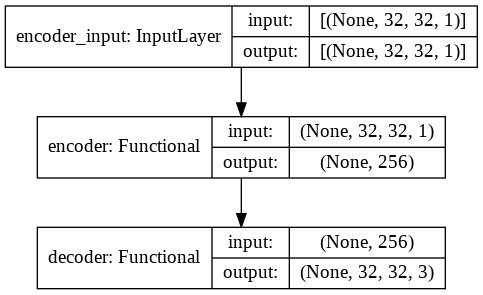

In [200]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64,128, 256]
autoencoder=build_autoencoder(input_shape,layer_filters,kernel_size,latent_dim)
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

Epoch 1/30
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0139 - val_loss: 0.0138

Epoch 00001: val_loss improved from inf to 0.01377, saving model to /content/gdrive/My Drive/DeepLearning/saved_models/saved_models/colorized_ae_model_cifar10_001.h5
Epoch 2/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0133 - val_loss: 0.0125

Epoch 00002: val_loss improved from 0.01377 to 0.01248, saving model to /content/gdrive/My Drive/DeepLearning/saved_models/saved_models/colorized_ae_model_cifar10_002.h5
Epoch 3/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0130 - val_loss: 0.0176

Epoch 00003: val_loss did not improve from 0.01248
Epoch 4/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0125 - val_loss: 0.0135

Epoch 00004: val_loss did not improve from 0.01248
Epoch 5/30
1250/1250 [==============================] - 7s 6ms/step - loss: 0.0121 - val_loss: 0.0126

Epoch 00005: val_loss did not improve from 0.01

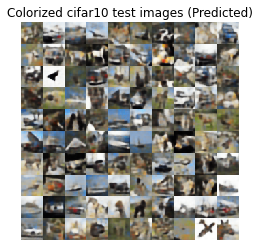

313/313 - 1s - loss: 0.0103

Test loss: 0.0103%


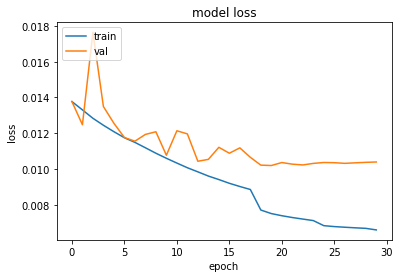

In [206]:
epochs =30
optimizer = 'RMSprop'
train_test_plot(autoencoder, x_train, x_val, x_train_gray, x_val_gray,x_test,x_test_gray, optimizer,epochs,batch_size,10)

In [ ]:
epochs =30
optimizer = 'RMSprop'
train_test_plot(autoencoder, x_train_100, x_val_100, x_train_gray_100, x_val_gray_100,x_test_100,x_test_gray_100, optimizer_100,epochs_100,batch_size_100,10)

In [ ]:
%cd /content/gdrive/My Drive/DeepLearning/saved_models
model = tf.keras.models.load_model('colorized_ae_model_cifar10_002.h5')
x_decoded = model.predict(x_test_gray)
  
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, 32,32,3))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized cifar{} test images (Predicted)'.format(10))
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

##Transfer Learning

In [222]:
## Import Pretrained resnet50 model using keras ##
from keras.applications import ResNet50,vgg16

def build_autoencoder_tf(input_shape,layer_filters,kernel_size,latent_dim):

  base_model= ResNet50(include_top=False,weights='imagenet',input_shape=(32, 32, 3))
  # For VGG16 Removing the last layer from the loaded model as we require only the features not the classification 
  base_model.layers.pop()
  base_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output,name="ResNet50")
  shape = base_model.layers[-3].output.shape
  inputs = tf.keras.Input(shape=(32, 32, 3))
  x = base_model(inputs)
  # generate a latent vector
  x = Flatten()(x)
  latent = Dense(latent_dim, name='latent_vector')(x)

  # instantiate encoder model
  encoder = Model(inputs, latent, name='encoder')
  encoder.summary()

  # build the decoder model
  latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
  x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
  x = Reshape((shape[1], shape[2], shape[3]))(x)

  # stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
  for filters in layer_filters[::-1]:
      x = Conv2DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          strides=4,
                          activation='relu',
                          padding='same')(x)
  outputs = x = AveragePooling2D(pool_size=(2,2))(x)
  outputs = Conv2DTranspose(filters=3,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            name='decoder_output')(x)
  
  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  decoder.summary()

  # autoencoder = encoder + decoder
  # instantiate autoencoder model
  autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
  autoencoder.summary()
  return autoencoder


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
ResNet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_41 (Flatten)         (None, 2048)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               524544    
Total params: 24,112,256
Trainable params: 24,059,136
Non-trainable params: 53,120
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________

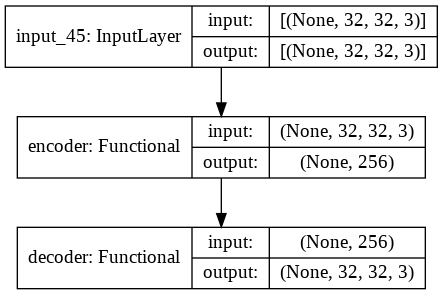

In [223]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64,128, 256]
autoencoder_1=build_autoencoder_tf(input_shape,layer_filters,kernel_size,latent_dim)
plot_model(autoencoder_1,to_file='autoencoder_1.png', show_shapes=True)

In [ ]:
epochs =5
optimizer = 'RMSprop'
train_test_plot(autoencoder_1, x_train, x_val, x_train_gray, x_val_gray,x_test,x_test_gray, optimizer,epochs,batch_size,10)

In [ ]:
epochs =30
optimizer = 'RMSprop'
train_test_plot(autoencoder_1, x_train_100, x_val_100, x_train_gray_100, x_val_gray_100,x_test_100,x_test_gray_100, optimizer_100,epochs_100,batch_size_100,100)